# **Generative Adversarial Networks(GANs)**
<img align='right' width='800' src="https://cdn-images-1.medium.com/v2/resize:fit:851/0*pPEL7ryJR51VpnDO.jpg">

## **SRGAN**

Super-resolution (SR) is upsampling a low-resolution image into a higher resolution with minimal information distortion.

**Traditional approches:**
- Interpolation-based Methods
- Regularization-based Methods

Single Image Super-Resolution focuses on learning a mapping function that directly maps from low-resolution to high-resolution images. It uses convolutional neural networks (CNNs). Researchers train these networks using large-scale datasets that include pairs of low-resolution and high-resolution images. These networks learn the underlying patterns and the relationships between the low relation and high resolutions of images so that it generates high-quality results.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os

import scipy

import torch
from torch import nn
import torchvision
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.datasets import MNIST, FashionMNIST
from torchvision import transforms

In [2]:
# Hyperparameters
EPOCH = 20
LR = 2e-4
BS = 32
C, H, W = 3, 24, 24
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Availabe device is: ", device)

Availabe device is:  cuda


In [3]:
# Visioalize the data
def show(tensor, ch=C, size=(H, W), num_to_display=16):
    """
    Inputs would be tensor with (batch_size, channel, height, weight) dimention
    First we detach() tensor so because it's not require grade any more,
    Then send it to cpu() to make sure the tensor doesn't on different device
    Matplotlib show images in (height, width, channel) dimention so the images permute to match the criteria
    """
    images = tensor.detach().cpu().view(-1, ch, *size)
    grid = make_grid(images[:num_to_display], nrow=4, normalize=True).permute(1, 2, 0)
    plt.axis(False)
    plt.imshow(grid)
    plt.show()

##**SrGAN architecture**

<img align='center' width='1200' src="https://production-media.paperswithcode.com/methods/Screen_Shot_2020-07-19_at_11.13.45_AM_zsF2pa7.png">

In [4]:
class convBlock(nn.Module):

    def __init__(self, in_channel, out_channel, use_bn=True, use_act=True, discriminator=False, **kw):
        super().__init__()
        self.use_act = use_act
        self.conv = nn.Conv2d(in_channel, out_channel, **kw, bias= not use_bn)
        self.bn = nn.BatchNorm2d(out_channel) if use_bn else nn.Identity()
        self.act = nn.LeakyReLU(0.2, inplace=True) if discriminator else nn.PReLU(out_channel)

    def forward(self, x):
        out = self.bn(self.conv(x))
        return self.act(out) if self.use_act else out

class skipBlock(nn.Module):

    def __init__(self, in_channel, out_channel):
        super().__init__()
        self.block1 = convBlock(
            in_channel, out_channel, kernel_size=3, stride=1, padding=1
        )
        self.block2 = convBlock(
            in_channel, out_channel, use_act=False, kernel_size=3, stride=1, padding=1
        )

    def forward(self, x):
        return x + self.block2(self.block1(x))

class upSample(nn.Module):

    def __init__(self, in_channel, up_factor=2,):
        super().__init__()
        out_c = in_channel * (up_factor ** 2)
        self.conv = nn.Conv2d(in_channel, out_c, 3, 1, 1) # (batch_size, C, H, W) --> (batch_size, C * 4, H, W)
        self.ps = nn.PixelShuffle(up_factor) # (batch_size, C, 2*h, 2*W)
        self.act = nn.PReLU(in_channel)

    def forward(self, x):
        return self.act(self.ps(self.conv(x)))

In [5]:
# Generator
class Generator(nn.Module):

    def __init__(self, in_channel=3, h_channel=64, n_block=16):
        super().__init__()
        self.initial = convBlock(in_channel, h_channel, use_bn=False, kernel_size=9, stride=1, padding=4)
        self.resblocks = nn.Sequential(
            *[skipBlock(64, 64) for _ in range(n_block)]
        )
        self.conv = convBlock(h_channel, h_channel, use_act=False, kernel_size=3, stride=1, padding=1)
        self.final = nn.Sequential(
            upSample(64),
            upSample(64),
            nn.Conv2d(h_channel, in_channel, 9, 1, 4)
        )


    def forward(self, x):
        initial = self.initial(x)
        x = self.resblocks(initial)
        x = self.conv(x) + initial

        return torch.tanh(self.final(x))


# Discriminator
class Discriminator(nn.Module):

    def __init__(self, in_c=3, h_feature=[64, 64, 128, 128, 256, 256, 512, 512]):
        super().__init__()
        conv_blocks = []
        for i, feature in enumerate(h_feature):
            layer = convBlock(
                in_c,
                feature,
                use_bn=False if i == 0 else True,
                discriminator=True,
                kernel_size=3,
                stride=1 if i%2 == 0 else 2,
                padding=1
            )

            conv_blocks.append(layer)
            in_c = feature

        self.final = nn.Sequential(
            *conv_blocks,
            nn.Flatten(),
            nn.Linear(512*6*6, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.final(x)



def test_models(device=device):
    x = torch.rand(10, 3, 24, 24).to(device)
    out = Generator().to(device)(x)
    pred = Discriminator().to(device)(out)
    print(f" --> input shape: {x.shape}\n --> Generator output size: {out.shape}\n --> Discriminator output size: {pred.shape}\n")
    return "Every thing is O.K"

test_models()

 --> input shape: torch.Size([10, 3, 24, 24])
 --> Generator output size: torch.Size([10, 3, 96, 96])
 --> Discriminator output size: torch.Size([10, 1])



'Every thing is O.K'

In [6]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

gen_noise = lambda number, z_dim: torch.randn(number, z_dim).to(device)

## **Perceptual Loss**

Use the loss function in the case of SRGANs which is Perceptual Loss, the combination of two different losses. They are Content loss and Adversarial loss.

$$
    \large \mathcal {l}^{SR} = \mathcal {l}^{SR}_{𝐗} + 10^{-3}\mathcal {l}^{SR}_{Gen}
$$

- **Content Loss $ (\mathcal {l}^{SR}_{𝐗})$:**

the paper’s authors decide to go with the loss of several VGG layers. The ReLU activation layers of the pre-trained 19-layer VGG network act as the foundation for this VGG loss which is the Euclidean distance between feature representations.

$$
    \large \mathcal {l}^{SR}_{VGG/i,j} = \frac{1}{W_{i,j}H_{i,j}} \sum^{W_{i,j}}_{x} \sum^{H_{i,j}}_{y} \left(\phi_{i,j}(I^{HR})_{x,y} - G_{\theta_{G}}(I^{LR})_{x,y} \right)^2
$$

<br>

With $\phi_{i,j}$ we indicate the feature map obtained by the j-th convolution
(after activation) before the i-th maxpooling layer within the
VGG19 network

Here $W_{i,j}$ and $H_{i,j}$ describe the dimensions of the respective feature maps within the VGG network.

- **Adversarial Loss$(\mathcal {l}^{SR})$:**

The usage of adversarial loss encourages the generator to produce highly realistic super-resolution images. The computation of adversarial loss is based on the predictions made by the discriminator. The generator tries to minimize this loss, while the discriminator tries to maximize it. SRGANs allow the generator network to learn and create super-resolved images that visually look like actual high-resolution images by including the adversarial loss.

$$
    \large {l}^{SR}_{Gen} = \sum^{N}_{1}{-\log{D_{\theta_{D}}(G_{\theta_{G}}(I^{LR}))}}
$$

Here, $D_{\theta_{D}}(G_{\theta_{G}}(I^{LR}))$ is the probability that the recon- structed image $G_{\theta_{G}}(I^{LR})$ s a natural HR image. For better gradient behavior we minimize $-\log{D_{\theta_{D}}(G_{\theta_{G}}(I^{LR}))}$ instead of $\log{[1 - D_{\theta_{D}}(G_{\theta_{G}}(I^{LR})]}$

<br>

##**Investigation of content loss**
- **SRGAN-MSE:** ${l}^{SR}_{MSE}$,to investigate the adversarial network with the standard MSE as content loss.

- **SRGAN-VGG22:** ${l}^{SR}_{VGG/2.2}$ with $\phi_{2,2}$, a loss defined on feature maps representing lower-level features

- **SRGAN-VGG54:** ${l}^{SR}_{VGG/5.4}$ with $\phi_{5,4}$, a loss defined on feature maps representing higher-level features from deeper
network layers with more potential to focus on the content of the images

<br>

[source](https://arxiv.org/abs/1609.04802)

In [7]:
class vggPartial(nn.Module):

    def __init__(self, device=device):
        super().__init__()
        self.vgg = torchvision.models.vgg19(weights='VGG19_Weights.IMAGENET1K_V1').to(device)
        self.vgg = self.vgg.eval()
        self.vgg.features[35].register_forward_hook(self._hook)

    def _hook(self, module, input, output):
        self.out = output

    def forward(self, x):
        self.vgg(x)
        return self.out

class vggLoss(nn.Module):

    def __init__(self, device=device):
        super().__init__()
        self.vgg = vggPartial()

    def forward(self, x, y):
        x = self.vgg(x)
        y = self.vgg(y)
        return F.mse_loss(x, y)


def test_vggLoss(device=device):
    loss = vggLoss()
    x = torch.rand(1, 3, 24, 24).to(device)
    y = torch.rand(1, 3, 96, 96).to(device)
    out = Generator().to(device)(x)
    return loss(out, y)

test_vggLoss()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:08<00:00, 64.1MB/s]


tensor(0.0286, device='cuda:0', grad_fn=<MseLossBackward0>)

In [ ]:
torch.cuda.empty_cache()
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "caching_allocator"
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb=512'
!export PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:512

In [54]:
def gen_loss_func(gen_net, disc_net, loss_func, content_loss, l_res, h_res):

    fake = gen_net(l_res)
    pred = disc_net(fake)
    regular_loss = loss_func(pred, torch.ones_like(pred))
    vgg_loss = content_loss(fake, h_res)
    bce = nn.MSELoss()
    # 1e-3 * regular_loss + 6e-3 * vgg_loss
    return 1e-3 * regular_loss + vgg_loss + bce(fake, h_res)


def disc_loss_func(gen_net, disc_net, loss_func, l_res, h_res):
    fake = gen_net(l_res)
    fake_pred = disc_net(fake.detach())  # detach() the generator output so it won't participate in gen_net learning
    real_pred = disc_net(h_res)

    loss_real = loss_func(real_pred, torch.ones_like(real_pred))
    loss_fake = loss_func(fake_pred, torch.zeros_like(fake_pred))

    return (loss_real + loss_fake) / 2

In [40]:
class dataSet(torch.utils.data.Dataset):

    def __init__(self, data, high_res=96):
        super().__init__()
        low_res = high_res // 4
        self.high_transform = transforms.Compose([
            transforms.Resize((high_res, high_res)),
            transforms.Normalize([.5, .5, .5],[.5, .5, .5]),
            # transforms.ToTensor()
        ])

        self.low_transform = transforms.Compose([
            transforms.Resize((low_res, low_res)),
            transforms.Normalize([.5, 0.5, 0.5],[0.5, 0.5, 0.5]),
            # transforms.ToTensor()
        ])

        self.both_transform = transforms.Compose([
            transforms.RandomCrop((high_res, high_res)),
            # transforms.RandomHorizontalFlip(p=0.5),
            # transforms.RandomRotation(90),
            transforms.ToTensor()
        ])


        self.data = data(root='data',
                         download=True,
                         transform=self.both_transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item, _ = self.data[idx]
        high = self.high_transform(item)
        low = self.low_transform(item)

        return low, high

In [41]:
data = dataSet(torchvision.datasets.LFWPeople)

Files already downloaded and verified


In [42]:
loader = torch.utils.data.DataLoader(data, 32)

In [ ]:
x, y = next(iter(loader))
show(x, size=(24, 24))
show(y, size=(96, 96))

In [43]:
from torch.utils.tensorboard import SummaryWriter
!rm -r /content/runs
writer = SummaryWriter("/content/runs")
writer_fake = SummaryWriter("/content/runs/fake")
writer_l = SummaryWriter("/content/runs/l_res")
writer_h = SummaryWriter("/content/runs/h_res")

In [ ]:
# !kill 5081
%load_ext tensorboard
%tensorboard --logdir=runs
# %reload_ext tensorboard

In [45]:
!rm -r $PATH
PATH = "/content/model/"
!mkdir $PATH

In [ ]:
!cp /content/drive/MyDrive/Gans_models/SRGAN_Gen_MSE /content
device

'cuda'

In [46]:
gen = Generator().to(device)
gen.apply(weights_init)
# gen.load_state_dict(torch.load('/content/SRGAN_Gen_MSE', map_location=device))
gen_opt = torch.optim.Adam(gen.parameters(), lr=2e-4, betas=(0.9, 0.999), eps=1e-4)
gen_exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(gen_opt, step_size=2, gamma=0.8)

disc = Discriminator().to(device)
disc.apply(weights_init)
# critic.load_state_dict(torch.load('/content/disc_20'))
disc_opt = torch.optim.Adam(disc.parameters(), lr=4e-4, betas=(0.9, 0.999), eps=1e-4)
disc_exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(disc_opt, step_size=2, gamma=0.8)

In [ ]:
step = 0
# content_loss = nn.MSELoss()
content_loss = vggLoss()
loss_func = nn.BCELoss()

for epoch in range(EPOCH):
    discLoss, genLoss = 0, 0
    print(f"\nEpoch: {epoch + 1}")

    for batch,  (l_res, h_res) in enumerate(tqdm(loader)):
        l_res = l_res.to(device)
        h_res = h_res.to(device)

        disc_opt.zero_grad()
        disc_loss = disc_loss_func(gen, disc, loss_func, l_res, h_res)
        disc_loss.backward() # If False, the graph used to compute the grad will be freed, Actually It isnt necessary
        disc_opt.step()

        gen_opt.zero_grad()
        gen_loss = gen_loss_func(gen, disc, loss_func, content_loss, l_res, h_res)
        gen_loss.backward()
        gen_opt.step()

        discLoss += disc_loss /len(data)
        genLoss += gen_loss /len(data)
        if batch % 30 == 0 and batch != 0:
            with torch.no_grad():
                step += 1
                fake = gen(l_res)
                image = h_res.view(-1, 3, H, W)
                h_res_grid = make_grid(h_res[:32], normalize=True)
                l_res_grid = make_grid(l_res[:32], normalize=True)
                fake_grid = make_grid(fake[:32], normalize=True)

                writer_fake.add_image(
                    "fake image", fake_grid, global_step=step
                )
                writer_l.add_image(
                    "Low_res image", l_res_grid, global_step=step
                )
                writer_h.add_image(
                    "High_res image", h_res_grid, global_step=step
                )

        writer.add_scalars("Loss", {
                    "Discriminator": discLoss,
                    "Generator": gen_loss
                }, (epoch+1)*batch)

    print(f'  Discriminator Loss: {discLoss:.4f} -- Generator Loss: {genLoss:.4f}')
    gen_exp_lr_scheduler.step()
    disc_exp_lr_scheduler.step()

    #Save model
    torch.save(gen.state_dict(), f"{PATH}Gen_{epoch+1}")
    torch.save(disc.state_dict(), f"{PATH}disc_{epoch+1}")

    # print(f"  >>> Generator Learning Rate: {gen_opt.param_groups[0]['lr']}")
    if (epoch + 1) % 2 == 0 and epoch > 0:
        print(f"  >>> Discriminator Learning Rate: {disc_opt.param_groups[0]['lr']}")
        print(f"  >>> Generator Learning Rate: {gen_opt.param_groups[0]['lr']}")

In [23]:
# !cp /content/model/Gen_10 /content/SRGAN_Gen

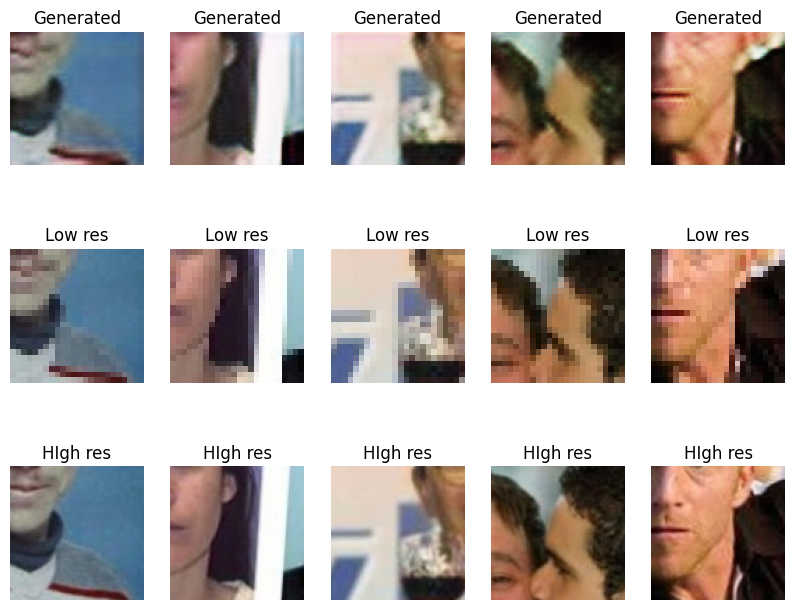

In [48]:
# gen.load_state_dict(torch.load('/content/model/Gen_18'))
fig = plt.figure(figsize=(10, 8))
for i, (l, h) in enumerate(loader):
    generated = gen(l.to(device))
    fig.add_subplot(3, 5, i+1)
    plt.imshow(((generated[0]+1)/2).detach().cpu().permute(1, 2 ,0))
    plt.axis(False)
    plt.title('Generated')
    fig.add_subplot(3, 5, i+6)
    plt.imshow(((l[0]+1)/2).detach().cpu().permute(1, 2 ,0))
    plt.axis(False)
    plt.title('Low res')
    fig.add_subplot(3, 5, i+11)
    plt.imshow(((h[0]+1)/2).detach().cpu().permute(1, 2 ,0))
    plt.axis(False)
    plt.title('HIgh res')
    if i == 4:
        break

plt.show()

In [95]:
from PIL import Image
def work_on_custome(gen, img_path, model_path='', train=False):
    img = np.array(Image.open(img_path))
    img = torch.from_numpy(img).permute(2, 0, 1)
    global l, h
    l = (torchvision.transforms.Resize((24, 24), antialias=True)(img) - 122.5) / 122.5
    h = (torchvision.transforms.Resize((96, 96), antialias=True)(img) - 122.5) / 122.5

    if os.path.isfile(model_path):
        print('Loading Generator ...')
        gen.load_state_dict(torch.load(model_path, map_location=device))

    if train:
        l_r = l.unsqueeze(0).to(device)
        h_r = h.unsqueeze(0).to(device)
        print('Train the Generator on face ...')
        for _ in range(100):
            gen_opt.zero_grad()
            gen_loss = gen_loss_func(gen, disc, loss_func, content_loss, l_r, h_r)
            gen_loss.backward()
            gen_opt.step()

    return gen(l.unsqueeze(0).to(device))

In [96]:
gen = Generator().to(device)
img_path = '/content/img.jpg'
model_path = '/content/drive/MyDrive/Gans_models/SRGAN_Gen'
generated = work_on_custome(gen, img_path, model_path, train=False)

Loading Generator ...


Text(0.5, 1.0, 'HIgh res')

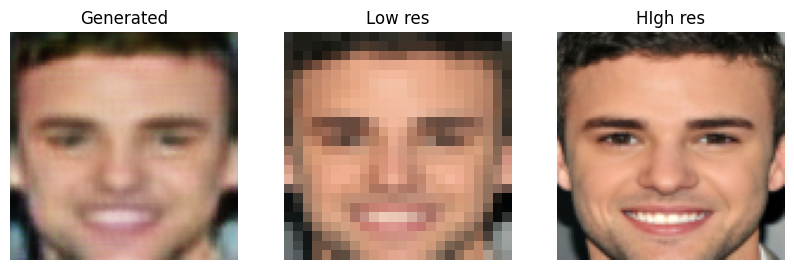

In [97]:
fig = plt.figure(figsize=(10, 8))
fig.add_subplot(1, 3, 1)
plt.imshow(((generated[0]+1)/2).detach().cpu().permute(1, 2 ,0))
plt.axis(False)
plt.title('Generated')
fig.add_subplot(1, 3, 2)
plt.imshow(((l+1)/2).detach().cpu().permute(1, 2 ,0))
plt.axis(False)
plt.title('Low res')
fig.add_subplot(1, 3, 3)
plt.imshow(((h+1)/2).detach().cpu().permute(1, 2 ,0))
plt.axis(False)
plt.title('HIgh res')